# Extract representations

Now we start looking at representations in trained networks.

We will first take a look at loading and saving models. For more details see 
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
# Training settings
input_size=(1,28,28,)
batch_size=64
test_batch_size=1000
epochs=1
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [4]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

0it [00:00, ?it/s]

9920512it [00:07, 1374213.69it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 84818.65it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 928209.89it/s]                              
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 34175.70it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [7]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


# Exercise

We saved before the trained network ```mnist_cnn.pt``` with ```model.state_dict()```.
Now we see how to load it and explore a bit its representations.
First of all we take a look at the ```model.parameters()```. Then we load the model parameters to
reconstruct the trained model. The we try to figure out how to extract the activations in hidden layers and
take a look at it with T-SNE. We will not explain T-SNE, the docs are at: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [8]:
model.parameters()

<generator object Module.parameters at 0x7fd2f190da20>

In [9]:
print("model's state_dict:")
for p in model.state_dict():
    print(p, "\t", model.state_dict()[p].size())


print("\noptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])

optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140543972429544, 140543972427456, 140543972426160, 140543972426592, 140543972427384, 140543972427312, 140543972426808, 140543972426664]}]


In [10]:
for i, p in enumerate(model.parameters()):
    print(i, p.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True


In [11]:
print(list(model.parameters())[4][0,0:10])

tensor([ 0.0272, -0.0286, -0.0184,  0.0234, -0.0131,  0.0106, -0.0341, -0.0158,
        -0.0351,  0.0106], grad_fn=<SliceBackward>)


In [12]:
#?optimizer

In [13]:
model.load_state_dict(torch.load('../mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
print(list(model.parameters())[4][0,0:10])

tensor([ 0.0294, -0.0331, -0.0191,  0.0137, -0.0137, -0.0016, -0.0474, -0.0206,
        -0.0379,  0.0117], grad_fn=<SliceBackward>)


Now that we have the trained model back we extract its representations, but how can we do that?
Think about that for a minute before going on...

In [15]:
inputs,labels = next(iter(test_loader))
print(inputs.shape)

torch.Size([1000, 1, 28, 28])


In [16]:
output = model(inputs).detach().numpy()

tensor(9)


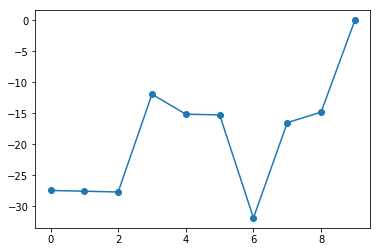

In [17]:
plt.plot(output[0,:],'-o')
print(labels[0])

In [18]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def extract(self,x):
        '''
        Extract representations from all layers
        '''
        oo = x
        o1 = F.relu(self.conv1(x))
        o2 = F.max_pool2d(o1, 2, 2)
        o3 = F.relu(self.conv2(o2))
        o4 = F.max_pool2d(o3, 2, 2)
        o5 = o4.view(-1, 4*4*50)
        o6 = F.relu(self.fc1(o5))
        o7 = self.fc2(o6)
        o8 = F.log_softmax(o7, dim=1)
        return [oo, o1,o2,o3,o4,o5,o6,o7,o8]       

In [34]:
model2 = Net2().to(device)
model2.load_state_dict(torch.load('../mnist_cnn.pt'))
model2.eval()
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [20]:
?model2.extract

In [32]:
reps = model2.extract(inputs)

In [33]:
_ = [print(i,r.shape) for i,r in enumerate(reps)]

0 torch.Size([1000, 1, 28, 28])
1 torch.Size([1000, 20, 24, 24])
2 torch.Size([1000, 20, 12, 12])
3 torch.Size([1000, 50, 8, 8])
4 torch.Size([1000, 50, 4, 4])
5 torch.Size([1000, 800])
6 torch.Size([1000, 500])
7 torch.Size([1000, 10])
8 torch.Size([1000, 10])


In general you don't want to do this for obvious reasons (memory,for example). You want to select relevant places from where to extract. Can you imagine some examples? Let's discuss.

In [23]:
inputs.shape

torch.Size([1000, 1, 28, 28])

In [24]:
feats = reps[5]
lasthidden = reps[6]

print(feats.shape)
print(lasthidden.shape)

torch.Size([1000, 800])
torch.Size([1000, 500])


In [25]:
#!pip install sklearn

In [35]:
import numpy as np
from sklearn.manifold import TSNE

In [36]:
feats_tsne = TSNE(n_components=2).fit_transform(feats.detach().numpy())

In [37]:
lh_tsne = TSNE(n_components=2).fit_transform(lasthidden.detach().numpy())

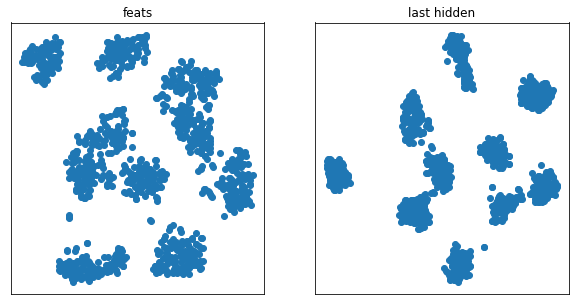

In [38]:
fig=plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(feats_tsne[:,0],feats_tsne[:,1])
plt.xticks([])
plt.yticks([])
plt.title('feats')

plt.subplot(122)
plt.scatter(lh_tsne[:,0],lh_tsne[:,1])
plt.xticks([])
plt.yticks([])
plt.title('last hidden')

plt.show()